In [1]:
%run Classes/SPDEs.ipynb
%run Classes/Rule.ipynb
%run Classes/Model.ipynb
%run Classes/Noise.ipynb
%run Classes/full_visualization.ipynb
%run Algorithms/Algorithm_2_FFT.ipynb
%run Classes/Burgers_PDE_FIND.ipynb

#Disable progress bars from tqdm
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

In [2]:
#Set global parameters

a, b, s, t = 0, 16, 0, 10 # space-time boundaries

X_, T_ = np.linspace(a,b,513), np.linspace(s,t,2001) # space-time grid for generating solutions
x_space = 1
t_space = 10
X, T = X_[::x_space], T_[::t_space] # space-time grid of observed points. O_X and O_T

eps = 0.2 #Viscosity

k = 120 # Number of realizations (multiple of 3)
m = 20 # Number of test cases, m < k

N = 10 # Number of experiments

noise = 0.0 #noise intensity

#Model parameters
height = 3
deg = 2.5
kernel_deg = 2
noise_deg = -1.5
free_num = 2
BC = 'P'

R = Rule(kernel_deg = kernel_deg,
         noise_deg = noise_deg,
         free_num = free_num) # initialize rule. No multiplicative width and forcing. 

#Polynomial interpolation parameters for PDE-FIND
deg_x = 5
deg_t = 5

true_eps = False #whether to use true value of eps (vs. estimated value) for PDE-FIND
finite_diff = True #whether to use finite difference (vs poly interpolation) for PDE-FIND

offset_x = 30
offset_t = 30

time_scale = 10 # increase the time interval for finer Euler scheme in PDE-FIND

In [3]:
%%time

exps_Alg2 = []
exps_v = []
exps_v_coef = []
exps_find = []
exps_find_eps =[]
exps_find_lambd =[]

for n in range(0,N):
    # Create realizations of initial conditions. 
    IC1 = Noise().initial(k//3, X_, scaling = 1) # one cycle
    IC2 = Noise().initial(k//3, X_, scaling = 2) # two cycles
    IC4 = Noise().initial(k//3, X_, scaling = 4) # four cycles

    IC = np.concatenate([IC1, IC2, IC4])

    W = np.zeros((k, len(T_), len(X_))) # No forcing
    
    #Generate solutions
    Burgers_ = SPDE(BC = BC, IC = IC, eps = eps).Burgers_FFT(W, T = T_, X = X_) # solve Burger's equations on the fine grid

    Burgers = Burgers_[:,::t_space,::x_space] # Observed points of Burger's equations
    
    Burgers = np.float32(Burgers)
    
    # Translate solution to a dataframe for the visualization class
    Burgers_true = [pd.DataFrame(B, index = T, columns = X) for B in Burgers]
    
    #
    test = np.random.choice(np.arange(k), m, replace = False) # choose test set
        
       
    Burgers_noise = np.array([B+np.random.normal(scale = noise*np.abs(B).mean().mean(), size = (len(T),len(X))) for B in Burgers_true])
    Burgers_noise = Burgers_noise.astype('float32')
    for i in range(k):
        Burgers_noise[i, :, -1] = Burgers_noise[i, :, 0]
    
    
    #ALGORITHM 2
    
    experiment_noise = IML(Burgers_noise,
                           Rule = R,
                           eps = eps,
                           height = height,
                           deg = deg,
                           T = T,
                           X = X) # initialize experiment for algorithm 2
    experiment_noise.set_train_test(test = test) # initialize test set

    experiment_noise.set_trees() # extract trees
    R.exceptions = set([tree for tree in experiment_noise.trees if '2' in tree])
    experiment_noise.set_trees([tree for tree in experiment_noise.trees if '2' not in tree])

    experiment_noise.training_models() # Create models for Step 2 of Algorithm 2
    
    
    experiment_noise.fit_training_model() # Linear fit for Step 2 of Algorithm 2
    experiment_noise.learn_with_fitted() # Recurcive steps 3 & 4 of Algorithm 2
    
    
    # Predicted values on the noisy data. Outliers that blow up during the experiment are excluded

    Prediction_noise = experiment_noise.to_df_list()
    show_prediction = summary(test)

    outliers = []
    #outliers = [i for i in range(len(test)) if show_prediction.one_error(i, Burgers_true, Prediction_noise) > 1]
    test_no_outliers = [test[i] for i in range(len(test)) if i not in outliers]
    Prediction_noise = [Prediction_noise[i] for i in range(len(test)) if i not in outliers]
    
    print('Numerical Scheme for Algorithm 2 failed for {} equation with the above coefficients.'.format(len(outliers)))
    
    # Errors
    show_no_outliers = summary(test_no_outliers)
    er = show_no_outliers.errors(Burgers_true, Prediction_noise, show = False, full = False)
    exps_Alg2.append(show_no_outliers)
    
    
    #ESTIMATE VISCOSITY
    
    # Regression to determine viscosity from train cases

    j = 0

    u_t = np.array([(Burgers_true[i].iloc[j+1].values-Burgers_true[i].iloc[j]).values/(T[1]-T[0])
                    for i in range(k) if i not in test]).flatten()

    dx = X[1]-X[0]

    M = SPDE(BC = 'P').Parabolic_Matrix(len(X)-1, 1, dx, inverse = False)

    u = np.array([Burgers_true[i].iloc[j].values for i in range(k) if i not in test])
    u_xx = np.array([np.dot(M, U) for U in u]).flatten()

    visc = lin_reg().fit(u_xx.reshape(-1, 1), u_t)
    exps_v_coef.append(visc.coef_)

    # Algorithm 2 on the true data with learnt viscosity eps

    experiment_v = IML(Burgers,
                       Rule = R,
                       eps = visc.coef_,
                       height = height,
                       deg = deg,
                       T = T,
                       X = X) # initialize experiment for algorithm 2
    experiment_v.set_train_test(test = test) # initialize test set

    experiment_v.trees = experiment_noise.trees # extract trees

    experiment_v.initialize_Predictions() 

    experiment_v.training_models() # Create models for Step 2 of Algorithm 2
    
    experiment_v.fit_training_model() # Linear fit for Step 2 of Algorithm 2
    experiment_v.learn_with_fitted() # Recurcive steps 3 & 4 of Algorithm 2
    
    Prediction_v = experiment_v.to_df_list()

    show_v = summary(experiment_v.test)
    er_find = show_v.errors(Burgers_true,Prediction_v, show = False)
    exps_v.append(show_v)
    
    
    #PDE-FIND
    
    # PDE-FIND with polynomial interpolation on the noisy data

    # Number of equations used for the PDE-FIND algorithm
    learning_samples = k-m

    u = np.array([Burgers_noise[i] for i in range(len(Burgers_noise)) if i not in test])

    dt, dx = T[1]-T[0], X[1]-X[0]
    # get viscosity and non linear coeficient of the Burgers equation
    # Use polynomial interpolation to differentiate the noisy data
    if finite_diff: eps_find, lambd_find = PDE_FIND_Burgers(u[:learning_samples], dt, dx, diff='finite_diff')
    else: eps_find, lambd_find = PDE_FIND_Burgers(u[:learning_samples],
                                                    dt,
                                                    dx,
                                                    diff='poly',
                                                    offset_x = offset_x,
                                                    offset_t = offset_t,
                                                    deg_x = deg_x,
                                                    deg_t = deg_t)
    exps_find_eps.append(eps_find)
    exps_find_lambd.append(lambd_find)

    S_ = np.linspace(T[0] , T[-1], time_scale*(len(T)-1)+1)

    IC_ = np.array([B[0] for B in Burgers_noise])

    W_ = np.zeros((k, len(S_), len(X)))

    if true_eps: eps_ = eps
    else: eps_ = eps_find

    Burgers_noise_FIND = SPDE(BC = 'P',
                              IC = IC_,
                              eps = eps_).Burgers_FFT(W_,
                                                      lambd = -lambd_find,
                                                      T = S_,
                                                      X = X)
                                                      
                                                       
    
    Burgers_noise_FIND = [pd.DataFrame(Burgers_noise_FIND[i, ::time_scale, :], index = T, columns = X) for i in test]
    
    #test_without_nan = test
    test_without_nan = [test[i] for i in range(len(test)) if not Burgers_noise_FIND[i].isnull().values.any()]
    Burgers_noise_FIND_ = [B for B in Burgers_noise_FIND if not B.isnull().values.any()]

    print('Numerical Scheme for PDE-FIND failed for {} equation with the above coefficients.'.format(len(test)-len(test_without_nan)))

    
    show_FIND = summary(test_without_nan)

    er_noise = show_FIND.errors(Burgers_true, Burgers_noise_FIND_, show = False, full = False)
    exps_find.append(show_FIND)
    
    print("Finished experiment", n+1)
    

Creating Model
Numerical Scheme for Algorithm 2 failed for 0 equation with the above coefficients.
Creating Model
Numerical Scheme for PDE-FIND failed for 0 equation with the above coefficients.
Finished experiment 1
Creating Model
Numerical Scheme for Algorithm 2 failed for 0 equation with the above coefficients.
Creating Model
Numerical Scheme for PDE-FIND failed for 0 equation with the above coefficients.
Finished experiment 2
Creating Model
Numerical Scheme for Algorithm 2 failed for 0 equation with the above coefficients.
Creating Model
Numerical Scheme for PDE-FIND failed for 0 equation with the above coefficients.
Finished experiment 3
Creating Model
Numerical Scheme for Algorithm 2 failed for 0 equation with the above coefficients.
Creating Model
Numerical Scheme for PDE-FIND failed for 0 equation with the above coefficients.
Finished experiment 4
Creating Model
Numerical Scheme for Algorithm 2 failed for 0 equation with the above coefficients.
Creating Model
Numerical Scheme f

In [4]:
for exps in [exps_Alg2, exps_v, exps_find]:

    print("Average average error:", np.mean([e.av_er for e in exps]))
    print("Maximum average error:", max([e.av_er for e in exps]))
    print("Minimum average error:", min([e.av_er for e in exps]))
    print('')

    print("Average maximum error:", np.mean([e.max_er for e in exps]))
    print("Maximum maximum error:", max([e.max_er for e in exps]))
    print("Minimum maximum error:", min([e.max_er for e in exps]))
    print('')

    print("Average minimum error:", np.mean([e.min_er for e in exps]))
    print("Maximum minimum error:", max([e.min_er for e in exps]))
    print("Minimum minimum error:", min([e.min_er for e in exps]))
    print('')

    print("=====================")

Average average error: 0.011491614344608485
Maximum average error: 0.015764099761612853
Minimum average error: 0.008456665154350234

Average maximum error: 0.04908839234746172
Maximum maximum error: 0.09384571633480515
Minimum maximum error: 0.02770761363090532

Average minimum error: 0.0012604934107144933
Maximum minimum error: 0.00254577648901588
Minimum minimum error: 0.00059844400959185

Average average error: 0.011399427379851649
Maximum average error: 0.015641513092418204
Minimum average error: 0.008406330727983148

Average maximum error: 0.048601263188825704
Maximum maximum error: 0.09231330979758934
Minimum maximum error: 0.02731753002769858

Average minimum error: 0.0013304016120411848
Maximum minimum error: 0.0026363217289888377
Minimum minimum error: 0.0006495188729334523

Average average error: 0.009215854560139578
Maximum average error: 0.023100907605212474
Minimum average error: 0.0051933811349299894

Average maximum error: 0.026709022316861276
Maximum maximum error: 0.10

In [5]:
print("Average viscosity:", np.mean(exps_v_coef))
print("Maximum viscosity:", max(exps_v_coef))
print("Minimum viscosity:", min(exps_v_coef))

Average viscosity: 0.17709208792695938
Maximum viscosity: [0.18245993]
Minimum viscosity: [0.17099517]


In [6]:
print("Average viscosity: {}, lambda: {}".format(np.mean(exps_find_eps), np.mean(exps_find_lambd)))
print("Maximum viscosity: {}, lambda: {}".format(max(exps_find_eps), max(exps_find_lambd)))
print("Minimum viscosity: {}, lambda: {}".format(min(exps_find_eps), min(exps_find_lambd)))

Average viscosity: 0.212483024601422, lambda: -0.9837357080301015
Maximum viscosity: 0.24627968147996943, lambda: -0.9788955718104302
Minimum viscosity: 0.20331845043728922, lambda: -0.9867363579797023


In [7]:
for exps in [exps_Alg2, exps_v, exps_find]:

    print("Average std:", np.mean([e.std_er for e in exps]))
    print("Maximum std:", max([e.std_er for e in exps]))
    print("Minimum std:", min([e.std_er for e in exps]))
    print('')

    print("=====================")

Average std: 0.011465683238896037
Maximum std: 0.018939526925513834
Minimum std: 0.007606253547918886

Average std: 0.011333906759308666
Maximum std: 0.018604472426593476
Minimum std: 0.007487985658659948

Average std: 0.0057582257883399286
Maximum std: 0.022049131278108616
Minimum std: 0.0024024532965536785



In [8]:
np.std(exps_v_coef)

0.0033011757837141417

In [37]:
np.std(exps_find_eps)

0.012181718129233026

In [38]:
np.std(exps_find_lambd)

0.0024396921431157734

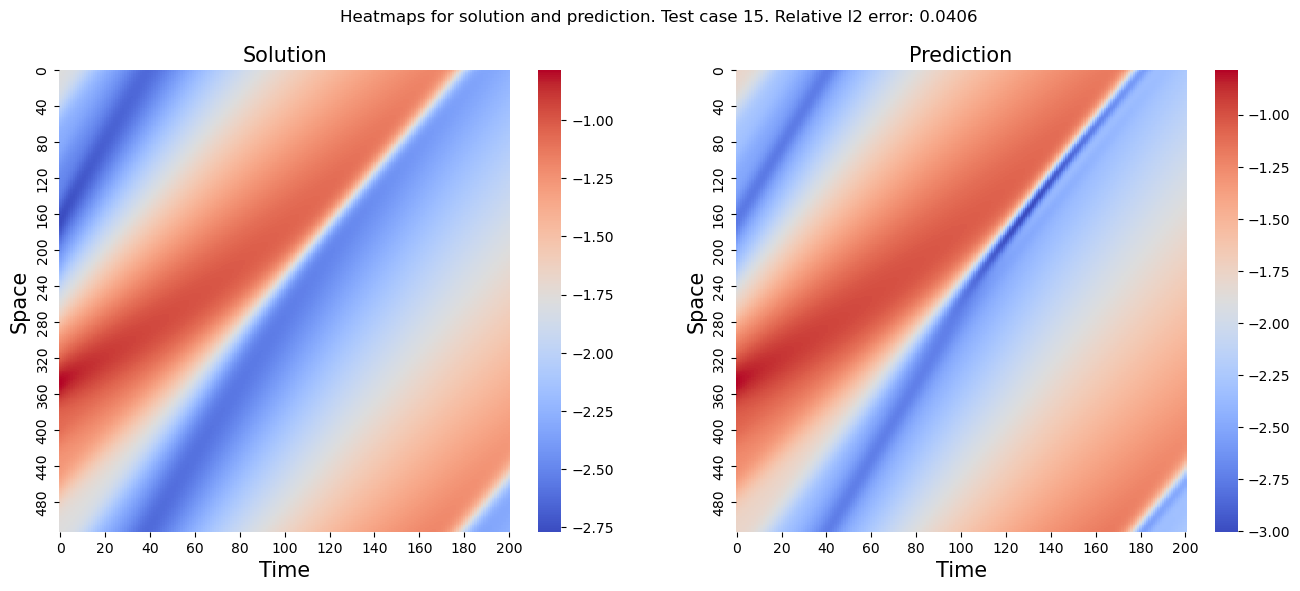

In [36]:
show_no_outliers.full_comparison(14, Burgers_true, Prediction_noise)

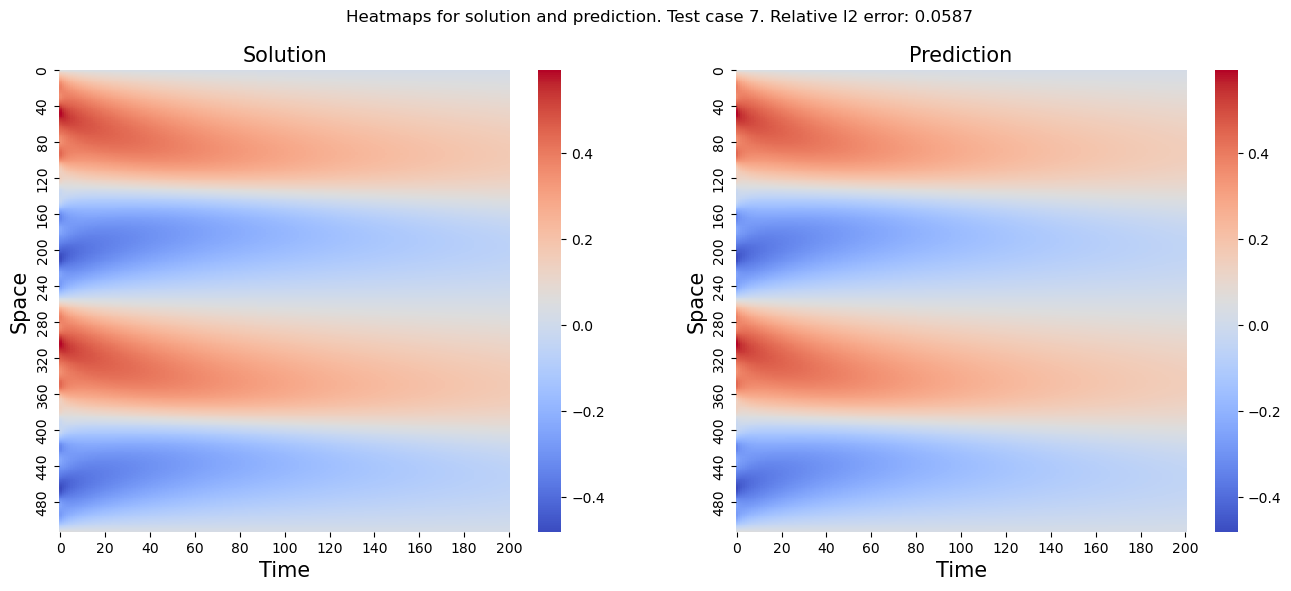

In [23]:
show_no_outliers.full_comparison(6, Burgers_true, Prediction_noise)